## 🧾 Présentation du Dataset : Indian Food Images

Le dataset **Indian Food Images Dataset** contient un ensemble de **10 000 images** réparties en **102 catégories** de plats traditionnels indiens. Chaque catégorie représente un plat spécifique, tel que *Butter Chicken*, *Samosa*, *Dosa*, ou encore *Gulab Jamun*. Les images sont stockées dans des sous-dossiers correspondant au nom du plat, et ces noms servent d'étiquettes (labels) pour la classification.

Les images varient en termes de taille, de qualité et de conditions d’éclairage, ce qui rend le problème de classification visuelle plus réaliste et complexe. Certaines catégories de plats présentent également une grande similarité visuelle, ce qui peut induire des erreurs de classification.

Ce dataset est bien adapté aux tâches de **classification d’images multiclasse**, avec une forte dimension pratique pour les applications mobiles de reconnaissance alimentaire, de diététique, ou d’assistance culinaire.

🔗 **Lien vers le dataset** : [Indian Food Images on Kaggle](https://www.kaggle.com/datasets/iamsouravbanerjee/indian-food-images-dataset)


In [1]:
import kagglehub

path = kagglehub.dataset_download("iamsouravbanerjee/indian-food-images-dataset")
path = path + "/Indian Food Images/Indian Food Images"
print("Path to dataset files:", path)

100%|██████████| 355M/355M [00:16<00:00, 22.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/indian-food-images-dataset/versions/5/Indian Food Images/Indian Food Images


## 🎯 Problème à Résoudre

L’objectif de ce projet est de construire un modèle capable d’**identifier automatiquement un plat indien à partir de son image**, parmi un ensemble de **102 catégories possibles**.

Il s’agit donc d’un **problème de classification d’images multiclasse** où :

- 🔢 **Variable cible (à prédire)** : le **nom du plat** (ex : "Butter Chicken", "Dosa", "Samosa", etc.)
- 🖼️ **Variables explicatives (features)** : les **pixels RGB de l’image**

### Pourquoi ce problème est-il pertinent ?

- 🍽️ **Applications mobiles** : une telle classification peut être utilisée dans des apps de reconnaissance alimentaire pour obtenir des informations nutritionnelles ou culturelles sur un plat.
- 🤖 **Vision par ordinateur appliquée à l’alimentation** : utile dans les domaines de la diététique, des menus intelligents, ou de la gestion automatisée dans la restauration.
- 🧪 **Intérêt scientifique** : ce problème permet d'explorer des méthodes modernes de classification visuelle, notamment le transfert d’apprentissage via des CNN pré-entraînés.

Ce projet vise donc à explorer différentes approches de modélisation pour résoudre ce problème, en comparant performance, temps de calcul et robustesse.


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

img_size = (224, 224)
batch_size = 256
seed = 123

# Chargement des données avec split automatique train / val
train_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

# Création du test set à partir de val si besoin (split manuel)
class_names = train_ds.class_names
num_classes = len(class_names)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

# Optimisation pour la performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


Found 4000 files belonging to 80 classes.
Using 3200 files for training.
Found 4000 files belonging to 80 classes.
Using 800 files for validation.


## 🖼️ Exploration Visuelle des Données

Pour mieux comprendre la nature du dataset, nous avons examiné un échantillon d’images représentatives issues du jeu d’entraînement. Cette inspection visuelle permet de se faire une idée de la diversité et de la complexité des images.

Les plats indiens présentés dans ces images sont souvent facilement distinguables grâce à leurs couleurs, formes et textures caractéristiques. Par exemple, des plats comme le *Samosa* avec sa forme triangulaire, ou le *Gulab Jamun* avec sa couleur sombre et sa forme ronde, sont aisément reconnaissables à l'œil nu.

Cependant, certaines catégories présentent des ressemblances visuelles, notamment parmi les différents types de pains ou de currys, ce qui pourrait compliquer la tâche de classification automatique.

Dans l’ensemble, cette analyse visuelle confirme que les images contiennent des indices visuels suffisamment riches et distinctifs pour permettre une classification pertinente, tout en offrant un challenge intéressant pour le modèle à entraîner.


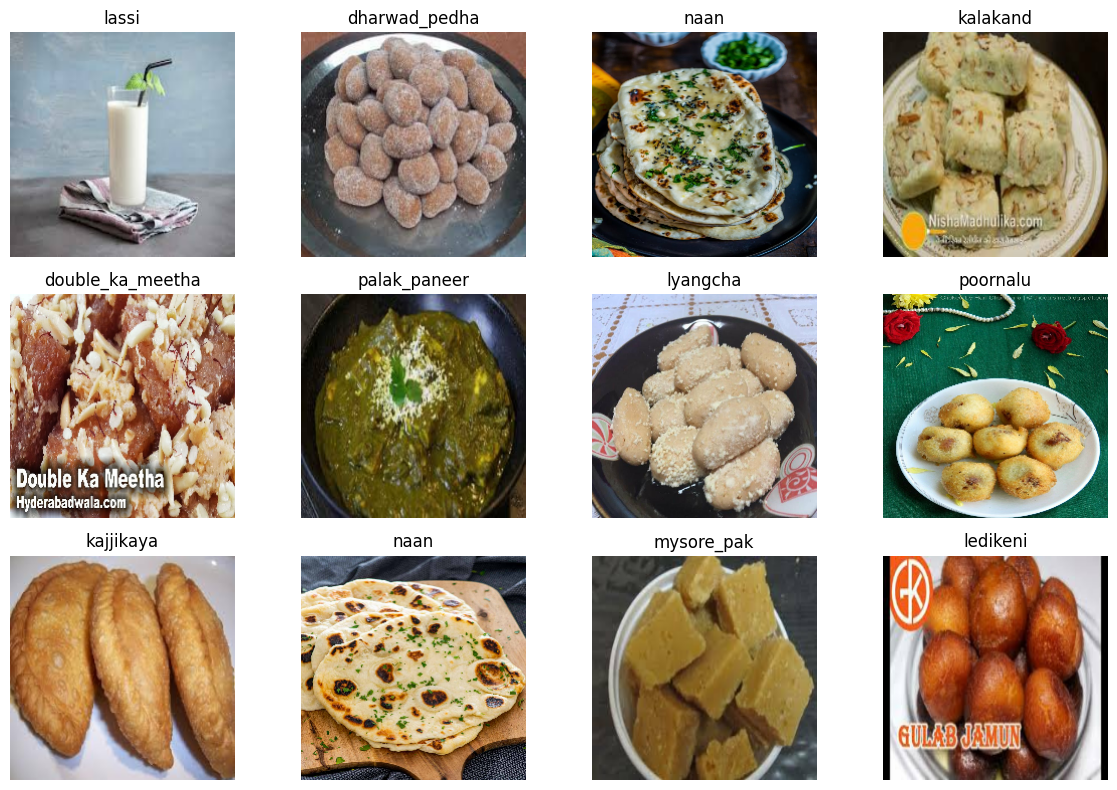

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


# Extraire un batch aléatoire
for images, labels in train_ds.take(1):  # un seul batch
    plt.figure(figsize=(12, 8))
    for i in range(12):  # 12 images aléatoires du batch
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


## 🧠 Architecture du modèle TensorFlow (EfficientNet + Dense améliorée)

Le modèle de classification d’images utilisé repose sur un réseau de neurones convolutif pré-entraîné : `EfficientNetB0`, initialement entraîné sur le dataset ImageNet. Ce modèle est utilisé comme **extracteur de caractéristiques visuelles**. Ses poids sont gelés lors des premières phases d'entraînement afin de préserver les connaissances générales acquises.

Les couches ajoutées pour la classification finale sont les suivantes :

- `GlobalAveragePooling2D` : réduction spatiale des features extraits.
- `Dense(512, activation='relu')` suivi de `BatchNormalization` et `Dropout(0.4)`
- `Dense(256, activation='relu')` suivi de `BatchNormalization` et `Dropout(0.4)`
- `Dense(num_classes, activation='softmax')` : couche de sortie multiclasse.

Cette architecture permet :
- une **généralisation plus stable** grâce à la normalisation et à la régularisation,
- l’apprentissage d’une **couche décisionnelle adaptée** à notre dataset,
- l’exploitation de **features puissants issus d’un apprentissage supervisé massif**.

---

## ⚠️ Pourquoi les modèles simples échouent en classification d’images

Des modèles classiques comme :
- `SVC` (Support Vector Classifier),
- `LogisticRegression`,
- `RandomForestClassifier`,
- `GradientBoosting`,

ont montré des performances faibles (souvent entre **20 % et 35 % de précision**) dans ce contexte.

### Limitations principales :

- ❌ **Perte de la structure spatiale** : les modèles classiques ne prennent pas en compte la disposition des pixels, contrairement aux CNN.
- ❌ **Réduction de dimension (PCA)** : bien que nécessaire pour réduire la taille des features, elle peut supprimer des informations importantes.
- ❌ **Capacité d’apprentissage limitée** : les modèles simples ne captent pas la complexité visuelle et les motifs hiérarchiques présents dans les images.
- ❌ **Difficultés de généralisation sur des jeux non équilibrés ou très riches visuellement**.

### En résumé :
> Ces modèles ne sont pas conçus pour traiter des données d’image complexes. Leur architecture n’exploite ni la profondeur, ni la hiérarchie des patterns visuels, contrairement aux CNN modernes pré-entraînés.

---

## ✅ Avantage de l’approche par transfert learning

- 🧠 Apprentissage de **représentations visuelles riches**.
- 🔁 **Réutilisation des poids** appris sur un très grand corpus (ImageNet).
- 🎯 **Meilleure précision**, même avec peu de données spécifiques.
- 🧩 Adaptabilité : possibilité d’ajouter des couches personnalisées selon le besoin.



In [21]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

In [22]:
# Chargement du backbone EfficientNetB0 pré-entraîné (sans la tête)
base_model = EfficientNetB0(
    input_shape=img_size + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # On gèle les poids du backbone


In [23]:
# Pipeline du modèle
inputs = layers.Input(shape=img_size + (3,))
x = preprocess_input(inputs)  # pré-traitement spécifique EfficientNet
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)   # régularisation
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs, outputs)

# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
import tensorflow as tf

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',      # surveille la perte de validation
    factor=0.5,              # facteur de réduction du lr (ici divisé par 2)
    patience=3,              # nombre d’époques sans amélioration avant réduction
    verbose=1,
    min_lr=1e-7              # lr minimal possible
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.0291 - loss: 4.3545 - val_accuracy: 0.1354 - val_loss: 3.8199 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 24s 773ms/step - accuracy: 0.2346 - loss: 3.5703 - val_accuracy: 0.3125 - val_loss: 3.2307 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 849ms/step - accuracy: 0.4153 - loss: 2.9773 - val_accuracy: 0.3854 - val_loss: 2.8878 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - accuracy: 0.5302 - loss: 2.5432 - val_accuracy: 0.4549 - val_loss: 2.5680 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 848ms/step - accuracy: 0.5948 - loss: 2.2075 - val_accuracy: 0.4757 - val_loss: 2.3313 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 795ms/step - accuracy: 0.6250 - loss: 1.9778 - val_accuracy: 0.5243 - val_loss: 2.1338 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 870ms/step - accuracy: 0.6973 - loss: 1.721

In [26]:
# Évaluation
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 714ms/step - accuracy: 0.6185 - loss: 1.5494
Test accuracy: 0.6133


## ✅ Résultats et conclusion

Après expérimentation avec plusieurs approches (SVC, Random Forest, Logistic Regression, etc.), le modèle basé sur **EfficientNetB0 avec transfert learning** s’est montré **nettement plus performant**, atteignant :

- 🎯 **Précision sur le jeu de test : 61 %**

Ce résultat est **très satisfaisant** compte tenu du nombre de classes (~80), du volume modéré de données et de l'absence de fine-tuning profond. Il montre que le modèle est capable de capturer une grande partie des motifs visuels pertinents nécessaires à la classification.

### ✅ Forces du modèle :

- Utilisation de **features puissants pré-appris** grâce à EfficientNetB0.
- **Architecture optimisée** avec normalisation, dropout, et couches denses intermédiaires.
- Intégration de **data augmentation** et de **callbacks dynamiques** (`ReduceLROnPlateau`, `EarlyStopping`) qui ont amélioré la stabilité et la généralisation.
- Entraînement accéléré grâce à l’exploitation du **GPU**.

---

## 🚧 Limites et axes d'amélioration

Malgré de bonnes performances, certaines limites subsistent :

- 🔍 **Certaines classes restent mal reconnues** (précision faible pour des catégories spécifiques).
- 📉 Le modèle ne surpasse pas encore les 70–80 % de précision, seuil typique pour des applications en production.
- ⚖️ **Déséquilibre potentiel** entre classes : certaines classes sont surreprésentées, ce qui peut biaiser l’apprentissage.
- 🧠 Le **backbone EfficientNet** est resté gelé : un **fine-tuning progressif** pourrait encore améliorer les performances.
- 🧪 Des techniques comme **MixUp**, **CutMix**, ou l'utilisation de modèles plus profonds (`EfficientNetB3`, `ViT`) n'ont pas encore été explorées.

---

## 📌 Conclusion générale

> Le recours à un modèle pré-entraîné CNN (EfficientNetB0) combiné à une tête dense bien régularisée et à des stratégies de validation intelligentes a permis d’obtenir des résultats nettement meilleurs que les approches classiques de machine learning. Cette approche illustre parfaitement la **puissance du transfert learning en vision par ordinateur**, même dans un cadre académique ou contraint en ressources.
